In [1]:
import tweepy
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import re
import networkx as nx
from textblob import TextBlob
from wordcloud import WordCloud

In [2]:
CONSUMER_KEY = "kPgwkf0JGqZrjLZzechULLWoF"
CONSUMER_SECRET = "eo8U2NwrtQtztKSHZksM2jNua1y8lEWyA7wkih2MOipLULQ60X"
OAUTH_TOKEN = "1176905643678142468-FUqvvZA588SJGj0kZhJ64SutyrxtBv"
OAUTH_TOKEN_SECRET = "PnrT0QXQUkPhp9201U7dTiAwOXa77zZx2RcH7KEgK3yQM"

In [3]:
def auth_connection():
  auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
  auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
  api = tweepy.API(auth)
  return api

In [4]:
api = auth_connection()

In [5]:
def load_json(path: str):
  with open(path, "r") as F:
    return json.load(F)

In [6]:
all_tweets: list = load_json("tweets.json")

In [7]:
tweets = [tweet for tweet in all_tweets if tweet["retweeted"] == False]

In [8]:
# Zadatak 1
def mention_sorter(tweet):
  return len(tweet["entities"]["user_mentions"])

most_mentions = sorted(tweets, key = mention_sorter)[-5:]

def filter_mentions(data: list):
  out = []
  for x in data:
    out.append({"text": x["text"], "hash count": len(x["entities"]["hashtags"])})
  return out

pd.DataFrame(filter_mentions(most_mentions))

text  hash count
0  #DonaldTrump ❤️’s BABY KILLER #Putin @EricTrum...           2
1  Come on Celtics @NBA @celtics @smart_MS3 @rob_...           0
2  I’m still waiting on @WNBA @NBA @espn @SportsC...           0
3  Hey @ESPN @NBA @WNBA @ABCWorldNews @NBCNews @C...           1
4  The @GleagueSquadron @nbagleague is real! @OTB...           0

In [9]:
# Zadatak 2

def filter_mention_hashtag(tweet):
  return len(tweet["entities"]["hashtags"]) == len(tweet["entities"]["user_mentions"])

most_hashtags = tuple(filter(filter_mention_hashtag, tweets))

len(most_hashtags) / len(tweets) * 100

16.400000000000002


----
 Its a travel or a jumpball, not too hard @nba #nba #celtics 
----


----
 DINWIDDIE AT THE BUZZER!!! TO HIS OLD TEAM!!!! LEGOOOOOOO!!! #NBA #Mavs @NBA 
----



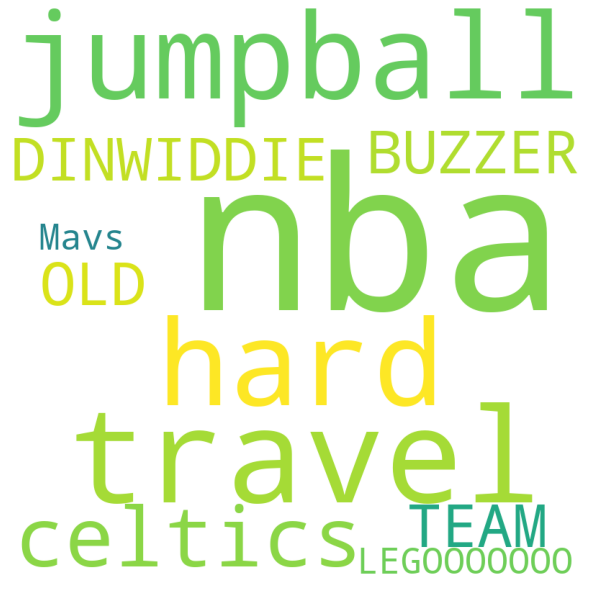

In [10]:
# Zadatak 3

isolated = tweets[400:450]

def filter_hahstag_exclusive(tweet):
  mentions_nba = any(True for text in tweet["entities"]["hashtags"] if "nba" in text["text"].lower())
  normal_nba_count = any(True for text in tweet["text"] if " nba " in text.lower())
  return mentions_nba and normal_nba_count == 0

filtered_hastags = list(filter(filter_hahstag_exclusive, isolated))

for i, x in enumerate(filtered_hastags):
  filtered_hastags[i] = x["text"]
  print("\n----\n", x["text"], "\n----\n")

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(" ".join(filtered_hastags))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [11]:
def filter_non_hash_text(tweet_text: str):
  rem_mentions = re.sub(r'@[^ ]+', '', tweet_text)
  rem_links = re.sub(r'https?://[^ ]+', '', rem_mentions)
  rem_emojis = re.compile("[" 
        u"\U0001F600-\U0001F64F" # emoticons
        u"\U0001F300-\U0001F5FF" # symbols & pictographs
        u"\U0001F680-\U0001F6FF" # transport & map symbols
        u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           "]+", 
        flags=re.UNICODE).sub("", rem_links)
  return rem_emojis

def filter_non_std_text(tweet_text: str):
  filtered = filter_non_hash_text(tweet_text)
  hastags_filtered = re.sub(r'#[^ ]+', '', filtered)
  return hastags_filtered

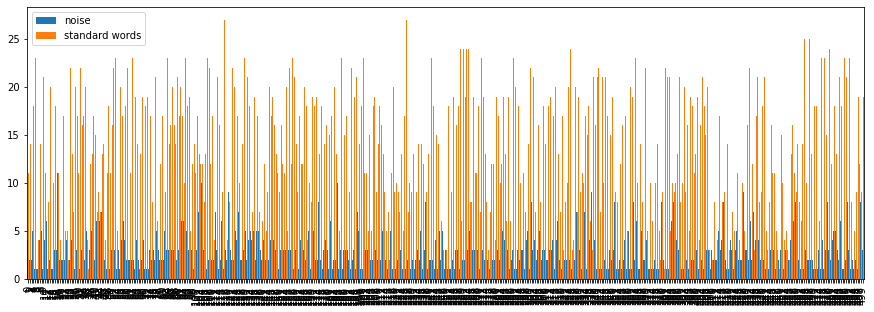

In [12]:
# Zadatak 4

def count_noise(tweet_text):
  noise_mentions = len(re.findall(r'@[^ ]+', tweet_text))
  noise_links = len(re.findall(r'https?://[^ ]+', tweet_text))
  noise_emojis = len(re.findall("[" 
        u"\U0001F600-\U0001F64F" # emoticons
        u"\U0001F300-\U0001F5FF" # symbols & pictographs
        u"\U0001F680-\U0001F6FF" # transport & map symbols
        u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           "]+", 
        tweet_text, flags=re.UNICODE))
  noise_hashtags = len(re.findall(r'#[^ ]+', tweet_text))

  return noise_mentions + noise_links + noise_emojis + noise_hashtags

def get_noise_normal_arr(tweets_list: list):
  out = []
  for tweet in tweets_list:
    tweet = tweet["text"]
    non_noise = len([x for x in filter_non_hash_text(tweet).split(" ") if x])
    noise = count_noise(tweet)
    out.append({"noise": noise, "standard words": non_noise})
  return out

pd.DataFrame(get_noise_normal_arr(tweets)).plot.bar(figsize=(15,5), width=1);

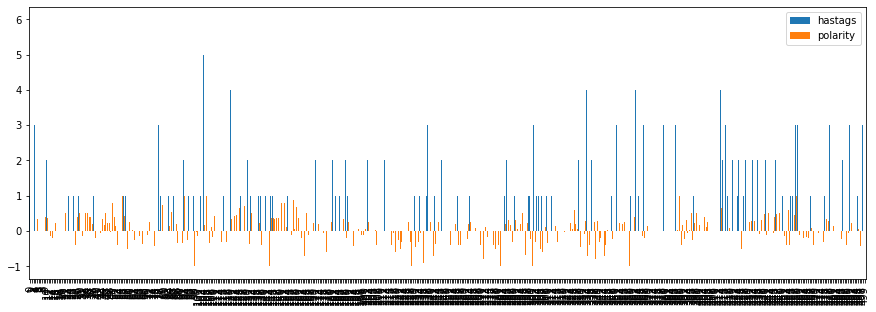

In [13]:
# Zadatak 5

filtered = [filter_non_hash_text(text["text"]) for text in tweets]

def polarity_scores(tweets_list: list):
  out = []
  for tweet in tweets_list:
    out.append({"hastags": tweet.count("#"), "polarity": TextBlob(tweet).sentiment.polarity})
  return out

pd.DataFrame(polarity_scores(filtered)).plot.bar(figsize=(15,5), width=1);

the


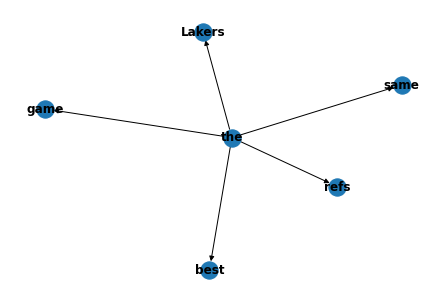

In [14]:
# Zadatak 6

filtered = [filter_non_std_text(text["text"]) for text in tweets]
std_text_only = "".join(filtered).split(" ")
std_text_only = [x for x in std_text_only if x]

most_common_word = Counter(std_text_only).most_common(1)[0][0]

print(most_common_word)

def words_after_word(all_tweets: list, word: str):
  out = []
  for tweet in all_tweets:
    found = re.findall(r"(?<=\b{}\s)(\w+)".format(word), tweet, re.IGNORECASE)
    if found:
      out += found
  return out


found_words = words_after_word(filtered, most_common_word)
most_common = Counter(found_words).most_common(5)

graph = nx.DiGraph()

for node in most_common:
  graph.add_edge(most_common_word, node[0])

nx.draw(graph, with_labels=True, font_weight="bold")
plt.show()